## Índice

- [4.a. Atualização](#4.a.-Atualização)
- [4.b. Preenchimento e consistência](#4.b.-Preenchimento-e-consistência)
- [5. Taxa de ocupação dos leitos de UTI](#5.-Taxa-de-ocupação-dos-leitos-de-uti)
    - [5.b. Comparação com painéis estaduais](#5.b.-Comparação-com-Painéis-Estaduais)
- [6. Quantidade de leitos de UTI existentes](#6.-Quantidade-de-leitos-de-UTI-existentes)

### Outros links
- [data-quality-numbers](#data-quality-numbers)

## Todo

- comparar leitos cnes com leitos api, ver se está muito fora
- medidas de desatualização por estado e tipo de gestão

In [61]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timezone, timedelta
import time
import glob
import gzip
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

In [65]:
from helpers.charts import plot_barh, plot_heatmap
import helpers.charts as charts

In [3]:
from helpers.get_cnes_data import get_all_hospital_data

## Ler dados

In [4]:
DATA_FOLDER = 'data/leitos/'

In [5]:
# data_files = glob.glob(f'{DATA_FOLDER}data_*.json.gz')
data_files = glob.glob(f'{DATA_FOLDER}data_*.csv.gz')
data_files.sort(reverse=True)
DATA_FILE = data_files[0]
print(DATA_FILE)

data/leitos/data_2021-03-09.csv.gz


In [6]:
# with gzip.open(DATA_FILE, 'r') as fin:
#     data = json.loads(fin.read().decode('utf-8'))
    
#     hits = data['hits']['hits']
#     df = pd.json_normalize(hits)

#     print(df.columns.values)
#     df.columns = [x.replace('_source.', '') for x in df.columns.values]

#     df.head()

# TS_RUN = pd.to_datetime(data['ts_run'])

In [7]:
df = pd.read_csv(DATA_FILE)

In [8]:
TS_RUN = pd.to_datetime(df.iloc[0]['ts_run'])

In [9]:
df.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run'],
      dtype=object)

## Limpar e criar features

In [10]:
# limpar siglas, muitas estão caixa baixa, preservando dado
df['estadoSigla_original'] = df['estadoSigla']
df['estadoSigla'] = df['estadoSigla'].str.upper()

In [11]:
df = df.fillna({
    'ofertaHospCli': 0,
    'ofertaSRAGCli': 0,
    'ofertaHospUti': 0,
    'ofertaSRAGUti': 0,
    'ocupHospCli': 0,
    'ocupSRAGCli': 0,
    'ocupHospUti': 0,
    'ocupSRAGUti': 0,
})

### Considerando oferta sem ocupação

In [12]:
df['totalOfertaCli'] = df['ofertaHospCli'] + df['ofertaSRAGCli']
df['totalOfertaUti'] = df['ofertaHospUti'] + df['ofertaSRAGUti']
df['totalOcupCli'] = df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOcupUti'] = df['ocupHospUti'] + df['ocupSRAGUti']

### Considerando oferta como oferta + ocupação

In [13]:
df['totalOfertaCliAlt'] = df['ofertaHospCli'] + df['ofertaSRAGCli'] + df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOfertaUtiAlt'] = df['ofertaHospUti'] + df['ofertaSRAGUti'] + df['ocupHospUti'] + df['ocupSRAGUti']

### Tem UTI

Tem alguma vaga ou ocupação de UTI, Hosp ou SRAG

In [14]:
df['has_uti_proxy'] = np.where(df['totalOfertaUtiAlt'] > 0, True, False)

### Dados de atualização

In [15]:
df['dataNotificacaoOcupacao'] = pd.to_datetime(df['dataNotificacaoOcupacao'])

In [16]:
UPDATED_DAYS = [1, 2, 7, 14, 90]
for d in UPDATED_DAYS:
    df[f'updated_{str(d)}d'] = np.where(df['dataNotificacaoOcupacao'] >= TS_RUN - timedelta(days=d, hours=TS_RUN.hour), True, False)

for d in UPDATED_DAYS:
    pct_outdated = len(df[df[f'updated_{str(d)}d'] == True]) / len(df)
    print(f'{round(pct_outdated * 100, 1)}% updated in {str(d)} days')

39.6% updated in 1 days
59.0% updated in 2 days
65.2% updated in 7 days
67.1% updated in 14 days
75.2% updated in 90 days


### Fazer consultas CNES

In [17]:
# df_hosp, errors = get_all_hospital_data(df)

# # salvar erros
# with open(f'data/hospitais_errors.json', 'w') as outfile:
#     json.dump(errors, outfile)

# # salvar dados
# df_hosp.to_json('exports/hospitais_cnes.json', orient='records')

In [18]:
# ler resultado
dtypes = {
    'cnes': str  # has left padding zeros
}
df_hosp = pd.read_json('exports/hospitais_cnes.json', dtype=dtypes)

### Merge dados API e dados CNES

In [19]:
df_h = df.merge(df_hosp, on='cnes', suffixes=('', '_cnes'), how='left')

In [20]:
df_h.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run',
       'estadoSigla_original', 'totalOfertaCli', 'totalOfertaUti',
       'totalOcupCli', 'totalOcupUti', 'totalOfertaCliAlt',
       'totalOfertaUtiAlt', 'has_uti_proxy', 'updated_1d', 'updated_2d',
       'updated_7d', 'updated_14d', 'updated_90d', 'id', 'noFantasia',
       'noEmpresarial', 'natJuridica', 'natJuridicaMant', 'cnpj',
       'tpPessoa', 'nvDependencia', 'nuAlvara', 'dtExpAlvara',
       'orgExpAlvara', 'dsTpUnidade', 'dsStpUnidade', 'noLogradouro',
       'nuEndereco', 'cep', 'regionalSaude', 'bairro', 'noComplemento',
       'municipio_cnes', 'noMunicipio', 'uf', 'tpGestao', 'nuTelefon

### Tentando diferenciar os desativados

- Não tem dados CNES & não foram atualizados nos últimos 14 dias
- OU Tem dados CNES & CNES == 'desativado' & não foram atualizados nos últimos 14 dias

In [21]:
df_deactivated = (df_h[
    ((df_h.id.isna()) & (df_h.updated_14d == False))
    |
    ((df_h.id.notna()) & (df_h.deactivated == True) & (df_h.updated_14d == False))
])
print('% deactivated proxy', len(df_deactivated) / len(df_h))

% deactivated proxy 0.06894750587620789


In [22]:
df_h['deactivated_proxy'] = np.where(df_h._id.isin(df_deactivated._id.unique()), True, False)

## Leitos CNES

In [23]:
all_beds = []
for index, row in df_h[df_h['beds'].notna()].iterrows():
    beds = row['beds']
    for bed in beds:
        bed['cnes'] = row['cnes']
        all_beds.append(bed)

In [24]:
df_beds = pd.DataFrame(all_beds)
df_beds['total_beds'] = df_beds['qtExistente'].astype(float)
df_beds.head()

,dsAtributo,coLeito,dsLeito,qtExistente,qtSus,cnes,total_beds
0,ESPEC - CIRURGICO,03,CIRURGIA GERAL,3,1,2249626,3.0
1,ESPEC - CIRURGICO,06,GINECOLOGIA,1,1,2249626,1.0
2,ESPEC - CLINICO,32,CARDIOLOGIA,2,1,2249626,2.0
3,ESPEC - CLINICO,33,CLINICA GERAL,23,10,2249626,23.0
4,OBSTETRICO,10,OBSTETRICIA CIRURGICA,1,1,2249626,1.0


In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_beds[df_beds.dsLeito.str[0:3] == 'UTI'].groupby(['dsLeito', 'dsAtributo']).total_beds.sum().sort_values(ascending=False))

dsLeito                                                       dsAtributo  
UTI II ADULTO-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19      COMPLEMENTAR    20273.0
UTI ADULTO - TIPO II                                          COMPLEMENTAR    15735.0
UTI NEONATAL - TIPO II                                        COMPLEMENTAR     4896.0
UTI ADULTO - TIPO III                                         COMPLEMENTAR     3540.0
UTI PEDIATRICA - TIPO II                                      COMPLEMENTAR     2336.0
UTI ADULTO - TIPO I                                           COMPLEMENTAR     1856.0
UTI NEONATAL - TIPO III                                       COMPLEMENTAR      882.0
UTI PEDIATRICA - TIPO III                                     COMPLEMENTAR      784.0
UTI II PEDIATRICA-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19  COMPLEMENTAR      609.0
UTI CORONARIANA TIPO II - UCO TIPO II                         COMPLEMENTAR      540.0
UTI NEONATAL - TIPO I                                         COM

### Leitos tipo UTI

In [26]:
df_beds['uti'] = np.where(
    df_beds.dsLeito.str[0:3] == 'UTI', 
        np.where(df_beds.dsLeito.str.contains('NEONATAL|QUEIMADOS') == False, True, False)
    , False)

### Somar leitos CNES UTI

In [27]:
cnes_uti = df_beds[df_beds['uti'] == True].groupby('cnes').agg({'total_beds': 'sum'})
cnes_uti.reset_index(inplace=True)
cnes_uti.rename(columns={'total_beds': 'uti_beds_via_cnes'}, inplace=True)
cnes_uti.head()

,cnes,uti_beds_via_cnes
0,0000396,10.0
1,0000418,70.0
2,0000426,123.0
3,0000434,143.0
4,0000477,98.0


In [28]:
df_hb = df_h.merge(cnes_uti, on='cnes', how='left')

## 4. Análise sobre qualidade dos dados

In [29]:
df_hb['no_cnes_name'] = np.where(df_hb.nomeCnes.isna(), True, False)
df_hb['no_cnes_code'] = np.where(df_hb.cnes.isna(), True, False)
df_hb['no_matching_cnes'] = np.where(df_hb.id.isna(), True, False)

cols_cnes = [
    'no_cnes_name',
    'no_matching_cnes',
    'deactivated',
]
df_hb['any_cnes_error'] = df_hb[cols_cnes].any(axis='columns')

df_hb['icu_total_ocup_gt_offer'] = np.where((df['totalOcupUti'] > df['totalOfertaUti']) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_hosp_ocup_gt_offer'] = np.where((df['ocupHospUti'] > df['ofertaHospUti']) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_covid_ocup_gt_offer'] = np.where((df['ocupSRAGUti'] > df['ofertaSRAGUti']) & (df_hb.has_uti_proxy == True), True, False)

for d in UPDATED_DAYS:
    df_hb[f'not_updated_{d}d'] = np.where(df_hb[f'updated_{d}d'] == True, False, True)


tolerance = 1.2
# icu
# df_hb['icu_total_ocup_gt_offer_tolerance'] = np.where((df['totalOcupUti'] >= (df['totalOfertaUti'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_hosp_ocup_gt_offer_tolerance'] = np.where((df['ocupHospUti'] >= (df['ofertaHospUti'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
df_hb['icu_covid_ocup_gt_offer_tolerance'] = np.where((df['ocupSRAGUti'] >= (df['ofertaSRAGUti'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
# non icu
# df_hb['cli_total_ocup_gt_offer_tolerance'] = np.where((df['totalOcupCli'] >= (df['totalOfertaCli'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
df_hb['cli_hosp_ocup_gt_offer_tolerance'] = np.where((df['ocupHospCli'] >= (df['ofertaHospCli'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)
df_hb['cli_covid_ocup_gt_offer_tolerance'] = np.where((df['ocupSRAGCli'] >= (df['ofertaSRAGCli'] * tolerance)) & (df_hb.has_uti_proxy == True), True, False)

cols_icu_ocup_tolerance = [
    'icu_hosp_ocup_gt_offer_tolerance',
    'icu_covid_ocup_gt_offer_tolerance',  
]
df_hb['any_icu_ocup_tolerance_error'] = df_hb[cols_icu_ocup_tolerance].any(axis='columns')

cols_all_ocup_tolerance = [
    'cli_hosp_ocup_gt_offer_tolerance',
    'cli_covid_ocup_gt_offer_tolerance',  
] + cols_icu_ocup_tolerance
df_hb['any_cli_icu_ocup_tolerance_error'] = df_hb[cols_all_ocup_tolerance].any(axis='columns')

df_hb['bad_state_code'] = np.where(df_hb['estadoSigla_original'].str.islower(), True, False)

cols_any_error = [
    'any_cnes_error',
    'any_cli_icu_ocup_tolerance_error',
    'any_icu_ocup_tolerance_error',
    'not_updated_14d',
#     'bad_state_code',
]
df_hb['any_error'] = df_hb[cols_any_error].any(axis='columns')

### 4.a. Atualização

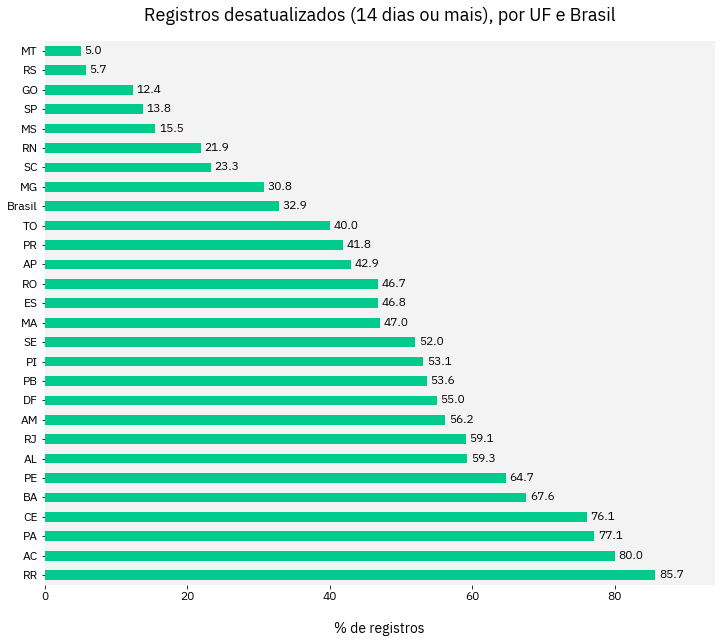

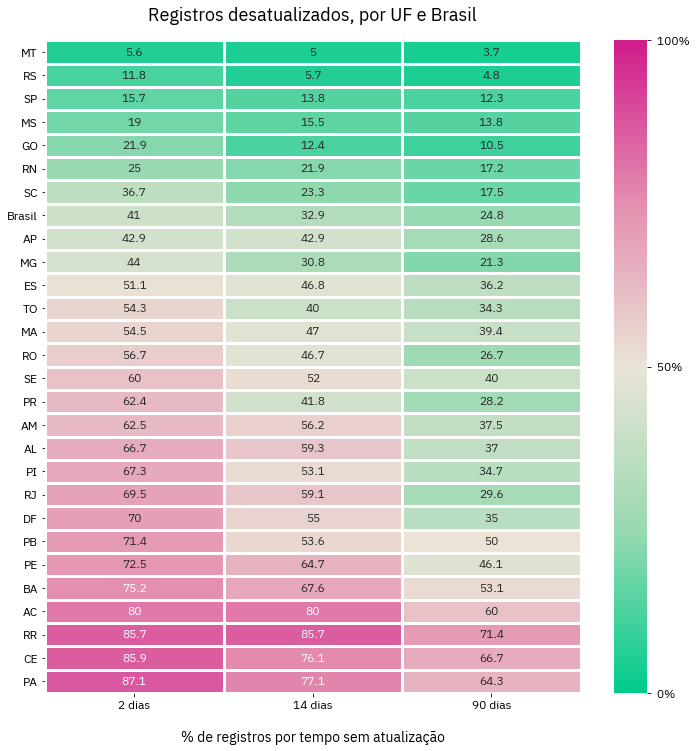

In [30]:
df_tmp = df_hb
# df_tmp = df_hb[df_hb.has_uti_proxy == True]

cols = [
    'not_updated_2d',
    'not_updated_14d',
    'not_updated_90d',
]

by_state = df_tmp.groupby('estadoSigla')[cols].sum().div(df_tmp.groupby('estadoSigla')['cnes'].size(), axis=0)
country = df_tmp.groupby('_index')[cols].sum().div(df_tmp.groupby('_index')['cnes'].size(), axis=0)
country['estadoSigla'] = 'Brasil'
check = by_state.append(country.set_index('estadoSigla'))

plot_barh(check, 'not_updated_14d', round_pct=True, ascending=True,
         title='Registros desatualizados (14 dias ou mais), por UF e Brasil',
         xlabel='% de registros',
         figsize=(12,10),
         file_name='desatualizados_geral')

plot_heatmap(check.sort_values('not_updated_2d'), cols, round_pct=True,
            xticklabels=['2 dias', '14 dias', '90 dias'],
            title='Registros desatualizados, por UF e Brasil',
            xlabel='% de registros por tempo sem atualização',
            figsize=(12,12),
            file_name='desatualizados_tabela')

### 4.b. Preenchimento e consistência
#### data-quality-numbers

In [31]:
df_tmp = df_hb

quality_check_cols = [
    'any_error',
    'any_cnes_error',
    'no_cnes_name',
#     'no_cnes_code',
    'no_matching_cnes',
    'deactivated',
#     'icu_total_ocup_gt_offer_tolerance',
#     'icu_hosp_ocup_gt_offer_tolerance',
#     'icu_covid_ocup_gt_offer_tolerance',
#     'any_ocup_tolerance_error',
    'not_updated_14d',
#     'bad_state_code',
#     'any_icu_ocup_tolerance_error',
    'any_cli_icu_ocup_tolerance_error',
]

# print('any_error:', round(df_tmp.set_index('cnes')[quality_check_cols].any(axis='columns').sum() / len(df_tmp) * 100, 1))

for col in quality_check_cols:
    print(f'{col}:', round(df_tmp.set_index('cnes')[[col]].any(axis='columns').sum() / len(df_tmp) * 100, 1))
    
df_uti = df_tmp[df_tmp.has_uti_proxy == True]
col = 'any_icu_ocup_tolerance_error'
print(f'{col}:', round(df_uti.set_index('cnes')[[col]].any(axis='columns').sum() / len(df_uti) * 100, 1))

any_error: 65.8
any_cnes_error: 16.4
no_cnes_name: 12.9
no_matching_cnes: 6.4
deactivated: 3.7
not_updated_14d: 32.9
any_cli_icu_ocup_tolerance_error: 40.3
any_icu_ocup_tolerance_error: 80.8


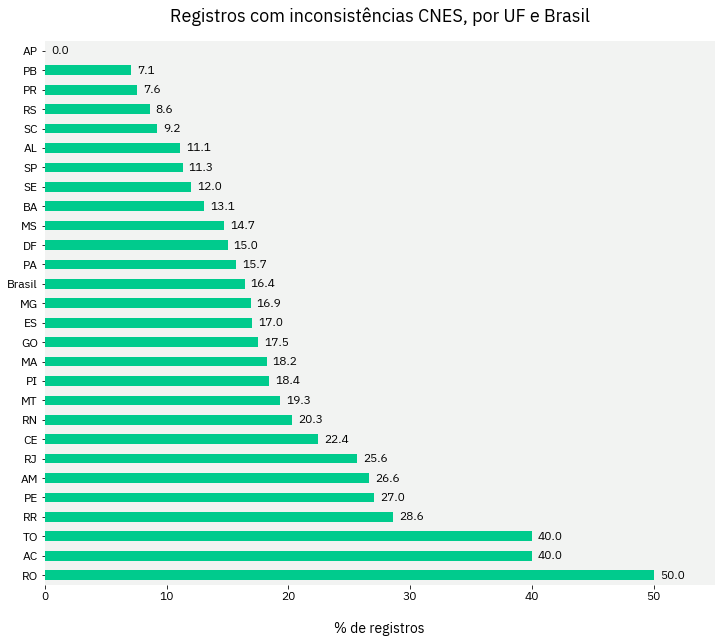

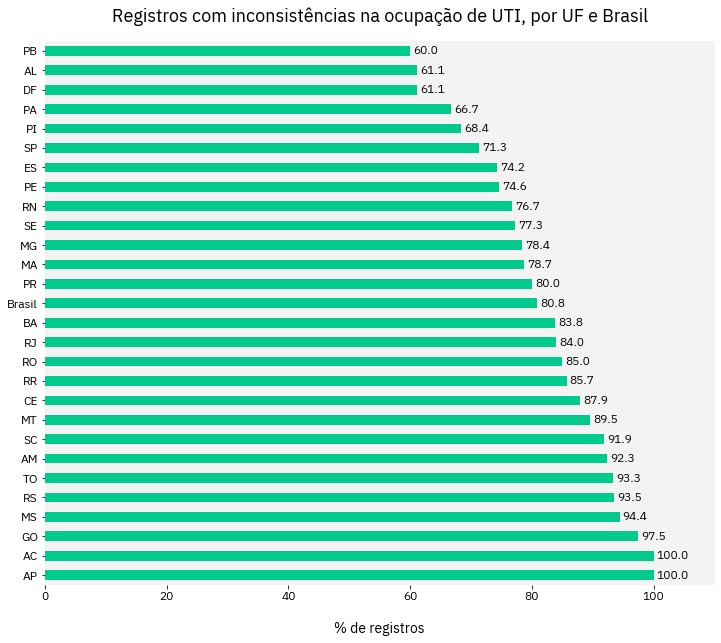

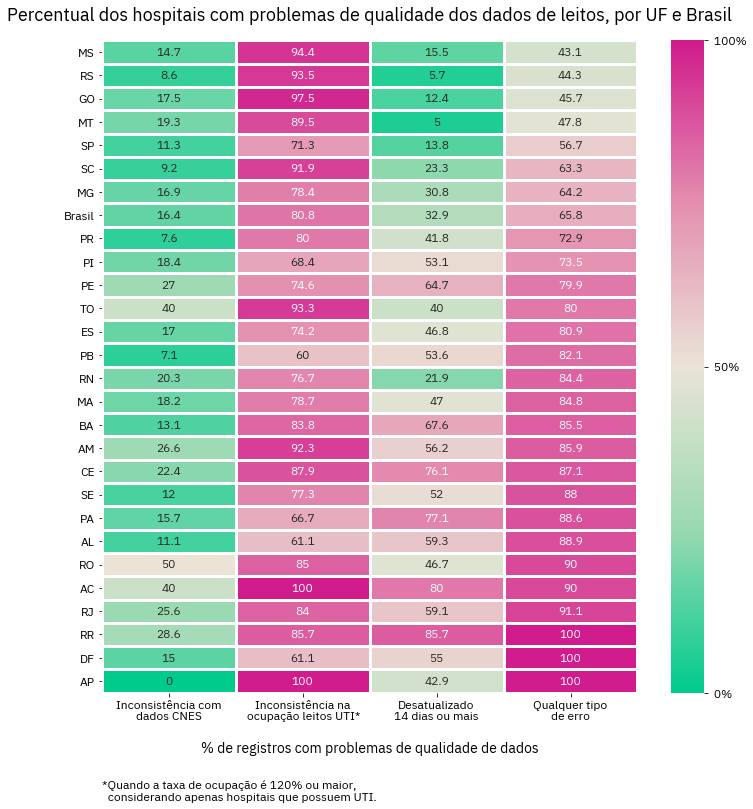

In [32]:
df_tmp = df_hb
df_uti = df_tmp[df_tmp.has_uti_proxy == True]

check_by_state = df_tmp.groupby('estadoSigla').agg({
    'any_error': 'sum',
    'any_cnes_error': 'sum',
#     'any_cli_icu_ocup_tolerance_error': 'sum',
    'not_updated_14d': 'sum'
}).div(df_tmp.groupby('estadoSigla')['cnes'].size(), axis=0)
 
check_by_state_uti = df_uti.groupby('estadoSigla').agg({
    'any_icu_ocup_tolerance_error': 'sum',
}).div(df_uti.groupby('estadoSigla')['cnes'].size(), axis=0)

country = df_tmp.groupby('_index').agg({
    'any_error': 'sum',
    'any_cnes_error': 'sum',
#     'any_cli_icu_ocup_tolerance_error': 'sum',
    'not_updated_14d': 'sum'
}).div(df_tmp.groupby('_index')['cnes'].size(), axis=0)

country_uti = df_uti.groupby('_index').agg({
    'any_icu_ocup_tolerance_error': 'sum',
}).div(df_uti.groupby('_index')['cnes'].size(), axis=0)

check_by_state = check_by_state.join(check_by_state_uti)
country = country.join(country_uti)
country['estadoSigla'] = 'Brasil'

check = check_by_state.append(country.set_index('estadoSigla'))
check = check.sort_values('any_error', ascending=True)

# plot
cols_order = [
    'any_cnes_error',
    'any_icu_ocup_tolerance_error',
    'not_updated_14d',
    'any_error',
]
xticklabels = [
    'Inconsistência com\ndados CNES',
    'Inconsistência na\n ocupação leitos UTI*',
    'Desatualizado\n14 dias ou mais',
    'Qualquer tipo\nde erro',
]
# check['any_error'] = round(1 - check['any_error'], 2)

plot_barh(check, 'any_cnes_error', round_pct=True, ascending=True,
         title='Registros com inconsistências CNES, por UF e Brasil',
         xlabel='% de registros',
         figsize=(12,10),
         file_name='inconsistencia_cnes'
         )

plot_barh(check, 'any_icu_ocup_tolerance_error', round_pct=True, ascending=True,
         title='Registros com inconsistências na ocupação de UTI, por UF e Brasil',
         xlabel='% de registros',
         figsize=(12,10),
         file_name='inconsistencia_uti'
         )

plot_heatmap(check.sort_values('any_error'), cols_order, round_pct=True,
            xticklabels=xticklabels, cols_order=cols_order,
            title='Percentual dos hospitais com problemas de qualidade dos dados de leitos, por UF e Brasil',
            xlabel='% de registros com problemas de qualidade de dados',
            file_name='ranking_qualidade_tabela',
            legend=f'*Quando a taxa de ocupação é {str(int(tolerance * 100))}% ou maior,\n  considerando apenas hospitais que possuem UTI.',
            legend_y=-0.15,
            figsize=(12,12)
            )

### Desatualizados por estado e tipo de gestão

In [33]:
df_h.groupby(['tpGestao', 'natJuridica']).size()

tpGestao  natJuridica
D         1.0             155
          2.0              29
          3.0             302
E         1.0             419
          2.0              40
          3.0             245
M         1.0            1247
          2.0             355
          3.0             791
          4.0               1
dtype: int64

In [34]:
types_natJuridica = {
    '1': 'ADMINISTRAÇÃO PÚBLICA',
    '2': 'ENTIDADES EMPRESARIAIS',
    '3': 'ENTIDADES SEM FINS LUCRATIVOS',
    '4': 'PESSOAS FÍSICAS', # claramente um erro 
}

types_tpGestao = {
    'D': 'Dupla',
    'E': 'Estadual',
    'M': 'Municipal',
}

<AxesSubplot:ylabel='estado,tpGestao'>

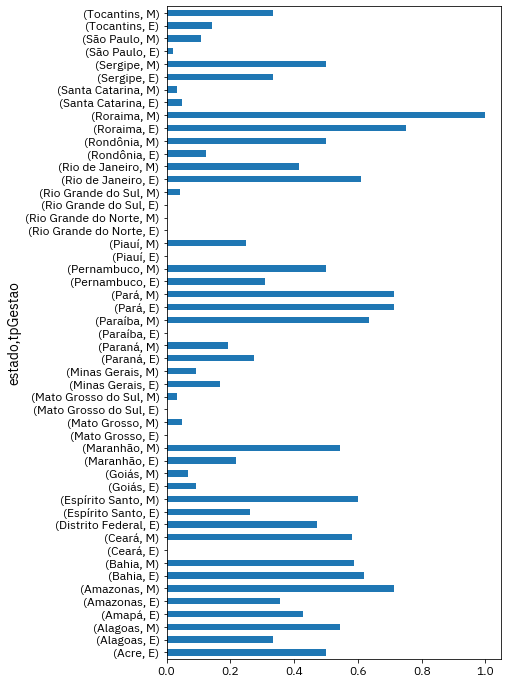

In [35]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
).plot.barh(figsize=(6,12))

In [36]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

df_tmp = (df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
)

df_tmp.reset_index().groupby(['tpGestao']).mean()

,0
tpGestao,
E,0.338683
M,0.393165


## 5. Taxa de ocupação dos leitos de uti

In [37]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

by_state = df_tmp.groupby('estado').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
})

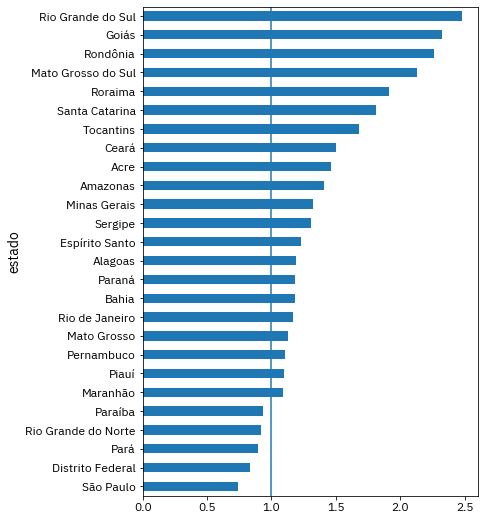

In [38]:
by_state['pct_occupied'] = by_state['totalOcupUti'] / by_state['totalOfertaUti']
by_state[by_state['pct_occupied'] < 10]['pct_occupied'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

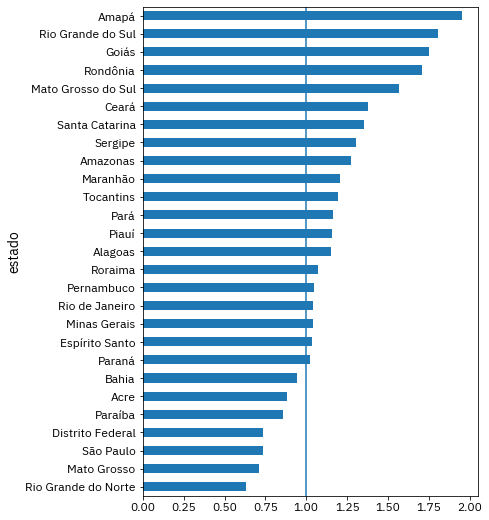

In [39]:
by_state['pct_occupied_cnes'] = by_state['totalOcupUti'] / by_state['uti_beds_via_cnes']
by_state[by_state['pct_occupied_cnes'] < 10]['pct_occupied_cnes'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

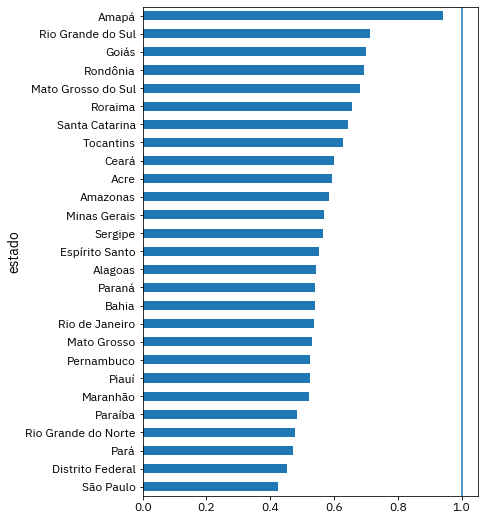

In [40]:
by_state['pct_occupied_alt'] = by_state['totalOcupUti'] / by_state['totalOfertaUtiAlt']
by_state[by_state['pct_occupied_alt'] < 10]['pct_occupied_alt'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

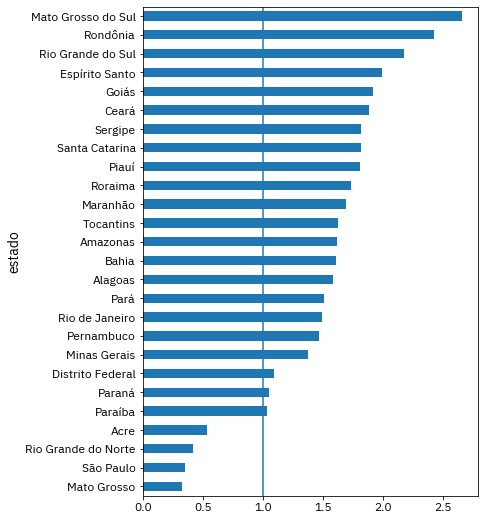

In [41]:
by_state['pct_occupied_hosp'] = by_state['ocupHospUti'] / by_state['ofertaHospUti']
by_state[by_state['pct_occupied_hosp'] < 10]['pct_occupied_hosp'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

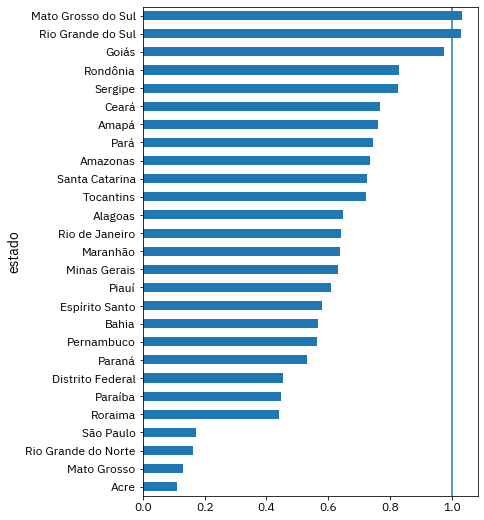

In [42]:
by_state['pct_occupied_cnes_hosp'] = by_state['ocupHospUti'] / by_state['uti_beds_via_cnes']
by_state[by_state['pct_occupied_cnes_hosp'] < 10]['pct_occupied_cnes_hosp'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

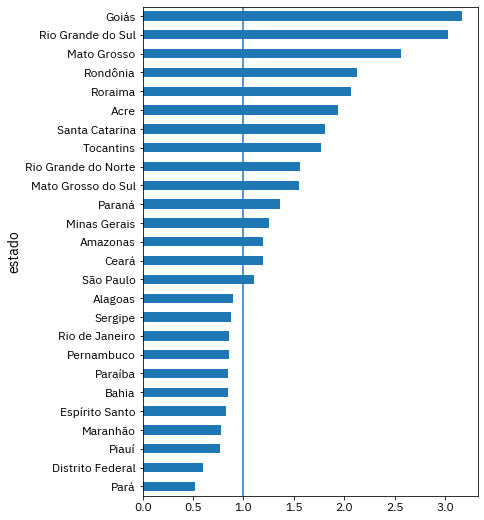

In [43]:
by_state['pct_occupied_srag'] = by_state['ocupSRAGUti'] / by_state['ofertaSRAGUti']
by_state[by_state['pct_occupied_srag'] < 10]['pct_occupied_srag'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

In [44]:
by_state

,_id,uti_beds_via_cnes,totalOfertaUti,totalOfertaUtiAlt,totalOcupUti,ofertaSRAGUti,ocupSRAGUti,ofertaHospUti,ocupHospUti,updated_7d,updated_14d,updated_90d,pct_occupied,pct_occupied_cnes,pct_occupied_alt,pct_occupied_hosp,pct_occupied_cnes_hosp,pct_occupied_srag
estado,,,,,,,,,,,,,,,,,,
Acre,2,126.0,76.0,187.0,111.0,50.0,97,26.0,14.0,1,1,2,1.460526,0.880952,0.593583,0.538462,0.111111,1.940000
Alagoas,17,452.0,439.0,960.0,521.0,255.0,229,184.0,292.0,9,9,14,1.186788,1.152655,0.542708,1.586957,0.646018,0.898039
Amapá,7,134.0,16.0,277.0,261.0,6.0,159,10.0,102.0,4,4,5,16.312500,1.947761,0.942238,10.200000,0.761194,26.500000
Amazonas,25,548.0,496.0,1194.0,698.0,247.0,295,249.0,403.0,12,14,21,1.407258,1.273723,0.584590,1.618474,0.735401,1.194332
Bahia,76,2349.0,1881.0,4099.0,2218.0,1051.0,886,830.0,1332.0,30,32,46,1.179160,0.944232,0.541108,1.604819,0.567050,0.843007
Ceará,60,1668.0,1536.0,3836.0,2300.0,858.0,1023,678.0,1277.0,27,28,30,1.497396,1.378897,0.599583,1.883481,0.765588,1.192308
Distrito Federal,17,774.0,687.0,1257.0,570.0,366.0,219,321.0,351.0,7,9,12,0.829694,0.736434,0.453461,1.093458,0.453488,0.598361
Espírito Santo,30,1263.0,1059.0,2363.0,1304.0,692.0,573,367.0,731.0,19,19,22,1.231350,1.032462,0.551841,1.991826,0.578781,0.828035
Goiás,116,1929.0,1451.0,4821.0,3370.0,471.0,1491,980.0,1879.0,105,108,109,2.322536,1.747019,0.699025,1.917347,0.974080,3.165605


### 5.b. Comparação com Painéis Estaduais

In [45]:
# dados secretarias estaduais
df_ses = pd.read_csv('ses/dados_secretarias.csv', sep=',')

df_ses['data_consulta'] = df_ses['ts_consulta'].str[:10]
df_ses['data'] = np.where(df_ses.data_autalizacao.notna(), df_ses.data_autalizacao, df_ses.data_consulta)

df_ses.head()

,estado,ts_consulta,data_autalizacao,hora_atualizacao,obs,fonte,fonte_url,uti_total_oferta,uti_total_bloquada,uti_total_ocupada,...,uti_covid_total_bloqueada,pct_uti_covid_total_ocupada,uti_covid_adulto_oferta,uti_covid_adulto_ocupada,pct_uti_covid_adulto_ocupada,uti_covid_pediatrica_oferta,uti_covid_pediatrica_ocupada,pct_uti_covid_pediatrica_ocupada,data_consulta,data
0,MT,2021-03-10 10:52:00,2021-03-09,17:37:39,NaN,"Painel Covid-19, Secretaria do Estado de Saúde...",http://www.saude.mt.gov.br/painelcovidmt2/,498.0,4.0,475.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-09
1,MA,2021-03-10 11:01:00,NaN,NaN,O painel é inconsistente internamente: em um l...,"Painel Coronavírus, Secretaria de Saúde",https://painel-covid19.saude.ma.gov.br/casos,NaN,NaN,NaN,...,NaN,0.853659,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-10
2,BA,2021-03-10 11:06:00,2021-03-09,19:22:00,NaN,Painel SEI Covid,https://infovis.sei.ba.gov.br/covid19/,NaN,NaN,NaN,...,NaN,0.867878,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-09
3,PA,2021-03-10 11:11:00,NaN,NaN,Leitos são “Somente gestão do Governo do Estad...,NaN,https://www.covid-19.pa.gov.br/#/,NaN,NaN,NaN,...,NaN,0.761616,487.0,373.0,0.765914,8.0,4.0,0.5,2021-03-10,2021-03-10
4,PB,2021-03-10 11:16:00,2021-03-10,11:00:13,NaN,Gestão de Leitos Covid-19 Paraíba,https://superset.plataformatarget.com.br/super...,NaN,NaN,NaN,...,NaN,0.803738,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-10


In [46]:
# estados sem dados
print('estados sem dados:', df_ses[(df_ses.uti_total_oferta.isna()) & (df_ses.uti_covid_total_oferta.isna())].estado.tolist())

estados sem dados: ['RJ']


In [47]:
df_ses.columns.values

array(['estado', 'ts_consulta', 'data_autalizacao', 'hora_atualizacao',
       'obs', 'fonte', 'fonte_url', 'uti_total_oferta',
       'uti_total_bloquada', 'uti_total_ocupada', 'pct_uti_total_ocupada',
       'uti_adulto_oferta', 'uti_adulto_bloqueada', 'uti_adulto_ocupada',
       'pct_uti_adulto_ocupada', 'uti_pediatrica_oferta',
       'uti_pediatrica_bloqueada', 'uti_pediatrica_ocupada',
       'pct_uti_pediatrica_ocupada', 'uti_covid_total_oferta',
       'uti_covid_total_ocupada', 'uti_covid_total_bloqueada',
       'pct_uti_covid_total_ocupada', 'uti_covid_adulto_oferta',
       'uti_covid_adulto_ocupada', 'pct_uti_covid_adulto_ocupada',
       'uti_covid_pediatrica_oferta', 'uti_covid_pediatrica_ocupada',
       'pct_uti_covid_pediatrica_ocupada', 'data_consulta', 'data'],
      dtype=object)

In [95]:
# calcular dados da api por estado, merge com dados secretarias estaduais
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]
# df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()

by_state = df_tmp.groupby('estadoSigla').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
}).reset_index()

by_state_ses = by_state.merge(df_ses, left_on='estadoSigla', right_on='estado', how='left')

by_state_ses['diff_uti_total_oferta'] = (by_state_ses['totalOfertaUti'] / by_state_ses['uti_total_oferta']) - 1
by_state_ses['diff_uti_total_ocup'] = (by_state_ses['totalOcupUti'] / by_state_ses['uti_total_ocupada']) - 1
by_state_ses['diff_uti_total_oferta_alt'] = (by_state_ses['totalOfertaUtiAlt'] / by_state_ses['uti_total_oferta']) - 1
by_state_ses['diff_uti_covid_total_oferta'] = (by_state_ses['ofertaSRAGUti'] / by_state_ses['uti_covid_total_oferta']) - 1
by_state_ses['diff_uti_covid_total_ocup'] = (by_state_ses['ocupSRAGUti'] / by_state_ses['uti_covid_total_ocupada']) - 1

# taxas de ocupação
by_state_ses['pctTotalOcupUti'] = (by_state_ses['totalOcupUti'] / by_state_ses['totalOfertaUti'])
by_state_ses['pctSRAGOcupUti'] = (by_state_ses['ocupSRAGUti'] / by_state_ses['ofertaSRAGUti'])
by_state_ses['diff_pct_uti_total_ocupada'] = (by_state_ses['pctTotalOcupUti'] / by_state_ses['pct_uti_total_ocupada']) - 1
by_state_ses['diff_pct_uti_covid_total_ocupada'] = (by_state_ses['pctSRAGOcupUti'] / by_state_ses['pct_uti_covid_total_ocupada']) - 1

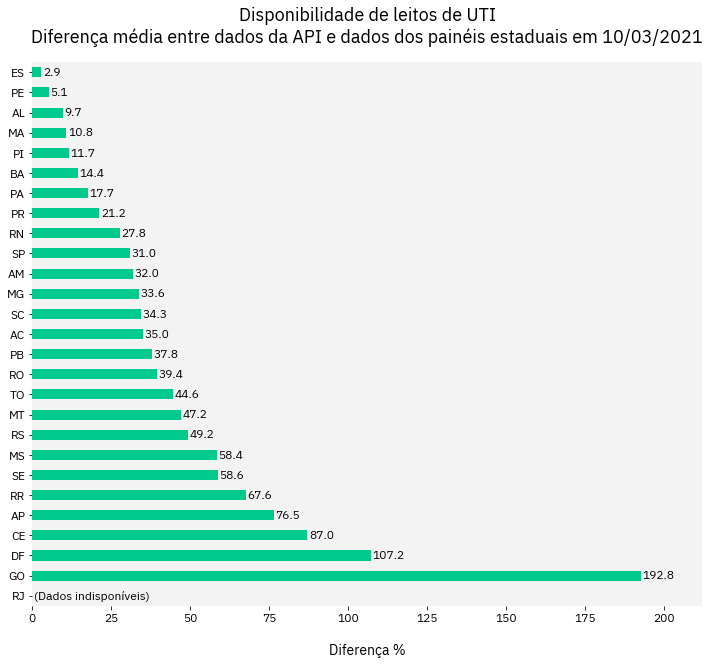

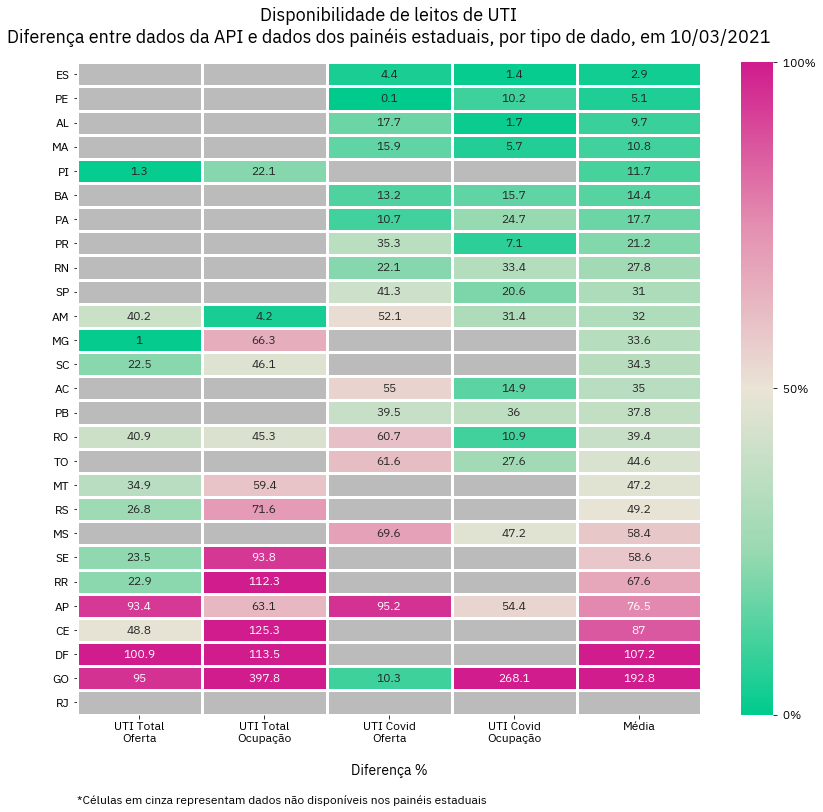

In [96]:
# diferença média por estado
cols = [
  'estadoSigla',
  'diff_uti_total_oferta',
  'diff_uti_total_ocup',
  'diff_uti_covid_total_oferta',
  'diff_uti_covid_total_ocup',
]
df_tmp = by_state_ses[cols].set_index('estadoSigla')
df_tmp = abs(df_tmp)
df_tmp = round(df_tmp * 100, 1)
df_mean = df_tmp.T.mean().sort_values(ascending=True)
# plot
df_chart = pd.DataFrame(df_mean)
df_chart.columns = ['mean']
plot_barh(df_chart, 'mean', round_pct=False, ascending=True,
         title='Disponibilidade de leitos de UTI\nDiferença média entre dados da API e dados dos painéis estaduais em 10/03/2021',
         xlabel='Diferença %',
         figsize=(12,10),
         file_name='diferenca_paineis_ses_media',
         zero_is_unavailable=True,
         )


# diferença por estado e por tipo de dado
# reorder to match df_mean order
df_heatmap = df_tmp.reindex(index=df_mean.reset_index()['estadoSigla'])
df_heatmap['diff_mean'] = round(df_mean, 1)
xticklabels = [
    'UTI Total\nOferta',
    'UTI Total\nOcupação',
    'UTI Covid\nOferta',
    'UTI Covid\nOcupação',
    'Média',
]
# plot
plot_heatmap(df_heatmap, df_heatmap.columns.values.tolist(), round_pct=False,
            xticklabels=xticklabels,
            title='Disponibilidade de leitos de UTI\nDiferença entre dados da API e dados dos painéis estaduais, por tipo de dado, em 10/03/2021',
            xlabel='Diferença %',
            figsize=(14,12),
            file_name='diferenca_paineis_ses_tabela',
            legend='*Células em cinza representam dados não disponíveis nos painéis estaduais',
            legend_y=-0.13,
            )

<AxesSubplot:ylabel='estadoSigla'>

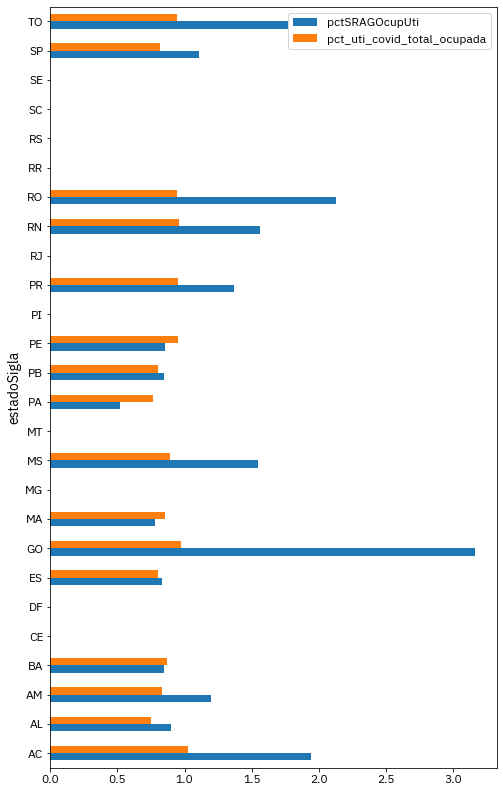

In [97]:
cols = [
    'estadoSigla',
#     'pctTotalOcupUti',
#     'pct_uti_total_ocupada',
    'pctSRAGOcupUti',
    'pct_uti_covid_total_ocupada',
]
df_tmp = by_state_ses[cols]
df_tmp = df_tmp[df_tmp.estadoSigla != 'AP']
# by_state_ses = by_state_ses[by_state_ses.pct_uti_covid_total_ocupada.notna()]
df_tmp['pctSRAGOcupUti'] = np.where(df_tmp.pct_uti_covid_total_ocupada.isna(), np.nan, df_tmp['pctSRAGOcupUti'])
df_tmp[cols].set_index('estadoSigla').plot.barh(figsize=(8,14))

## 6. Quantidade de leitos de UTI existentes
#### (Comparação com leitos CNES)

In [74]:
df_hb['bed_diff'] = df_hb['totalOfertaUti'] - df_hb['uti_beds_via_cnes']
df_hb['bed_diff_alt'] = df_hb['totalOfertaUtiAlt'] - df_hb['uti_beds_via_cnes']

count    1535.000000
mean       -4.485993
std        18.080391
min      -178.000000
25%       -10.000000
50%        -1.000000
75%         0.000000
max       280.000000
Name: bed_diff, dtype: float64


<AxesSubplot:>

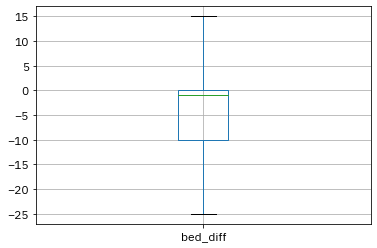

In [75]:
print(df_hb['bed_diff'].describe())
df_hb[['bed_diff']].boxplot(showfliers=False)

count    1535.000000
mean       25.637785
std        40.455028
min       -60.000000
25%         4.000000
50%        15.000000
75%        34.000000
max       435.000000
Name: bed_diff_alt, dtype: float64


<AxesSubplot:>

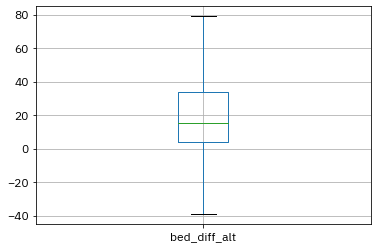

In [76]:
print(df_hb['bed_diff_alt'].describe())
df_hb[['bed_diff_alt']].boxplot(showfliers=False)

In [77]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]
df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()

by_state = df_tmp.groupby('estadoSigla').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
}).reset_index()

<ipython-input-77-53876912aefd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()


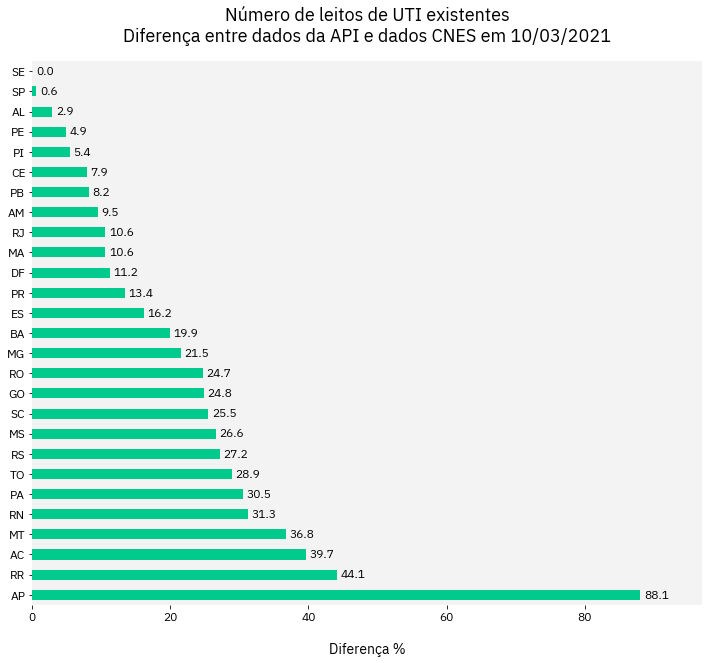

In [98]:
df_tmp = by_state.set_index('estadoSigla')
df_tmp['diff_uti_total_oferta'] = (df_tmp['totalOfertaUti'] / df_tmp['uti_beds_via_cnes']) - 1
df_tmp['diff_uti_total_oferta'] = round(abs(df_tmp[['diff_uti_total_oferta']]) * 100, 1)
df_tmp = df_tmp['diff_uti_total_oferta'].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12,10))

df_tmp.plot.barh(ax=ax, color=charts.OK_PRIMARY, zorder=3)

ax.set_xlim(0, round(df_tmp.max() * 1.1))
ax.set_facecolor('#f2f3f2')
# set_grid_x(ax)

ax.invert_yaxis()
ax.set_title('Número de leitos de UTI existentes\nDiferença entre dados da API e dados CNES em 10/03/2021', fontsize=charts.BIGGER_SIZE, pad=charts.M_LABEL_PAD)
ax.set_ylabel('')
ax.set_xlabel('Diferença %')
ax.xaxis.labelpad = charts.M_LABEL_PAD


# for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    label = str(round(width, 1))
    ax.annotate(label, xy=(left+width + 0.5, bottom+height/2), 
                ha='left', va='center')

# increase_chart_margins(plt)
charts.remove_chart_spines(ax)
# set_ticks(ax)

# set_axis(ax)

## Comparação com série histórica

In [ ]:
hist = pd.read_csv('data/2021-03-23_esus-vepi.LeitoOcupacao.zip')

In [ ]:
hist.columns.values

In [ ]:
len(hist)

In [ ]:
df[(df.estadoSigla == 'SP') & df.has_uti_proxy == True].sort_values('totalOcupUti', ascending=False)

In [ ]:
hist['dataNotificacao'] = pd.to_datetime(hist['dataNotificacao'])

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('---> dado série histórica \n')
    print(hist[(hist.cnes == 2080575)].sort_values('dataNotificacao', ascending=False)[10:11].iloc[0])

In [ ]:
cols = [
    'cnes', 
    'nomeCnes',
    'dataNotificacaoOcupacao',
    'ofertaHospCli',
    'ofertaHospUti',
    'ofertaSRAGCli',
    'ofertaSRAGUti',
    'ocupHospCli',
    'ocupHospUti',
    'ocupSRAGCli',
    'ocupSRAGUti',
    'altas',
    'obitos'
]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('---> dado API\n')
    print(df[df.cnes == '2080575'][cols].iloc[0])

## Athena

```sql
CREATE EXTERNAL TABLE IF NOT EXISTS datalake_medidasp.leitos (
  hits:array<struct<
    `_index`:string,
    `_type`:string,
    `_id`:string,
    `_score`:string,
    `_source.estado`:string,
    `_source.estadosigla`:string,
    `_source.municipio`:string,
    `_source.cnes`:string,
    `_source.nomecnes`:string,
    `_source.datanotificacaoocupacao`:string,
    `_source.ofertarespiradores`:string,
    `_source.ofertahospcli`:string,
    `_source.ofertahosputi`:string,
    `_source.ofertasragcli`:string,
    `_source.ofertasraguti`:string,
    `_source.ocuphospcli`:string,
    `_source.ocuphosputi`:string,
    `_source.ocupsragcli`:string,
    `_source.ocupsraguti`:string,
    `_source.altas`:string,
    `_source.obitos`:string,
    `_source.ocupacaoinformada`:string,
    `_source.algumaocupacaoinformada`:string>> 
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES (
  'serialization.format' = '1'
) LOCATION 's3://medidasp/leitos/'
TBLPROPERTIES ('has_encrypted_data'='false');
```